# 1. INTRODUÇÃO & OBJETIVOS

A Aprendizagem Automática desempenha um papel fundamental na análise de dados complexos, permitindo a construção de modelos capazes de identificar padrões relevantes e efetuar previsões com base em informação multidimensional. No domínio da análise musical, a aplicação destas técnicas possibilita o estudo sistemático de características acústicas, estruturais e contextuais, contribuindo para a compreensão de fenómenos como popularidade, estilo e comportamento auditivo.

No âmbito da unidade curricular de **Aprendizagem Automática (APRAU)** do **estrado em Engenharia Informática do ISEP**, este trabalho incide sobre a análise de um conjunto de dados constituído por *metadata* e descritores acústicos de faixas musicais. Cada instância representa uma música e está associada a duas variáveis alvo distintas: uma variável categórica, utilizada em tarefas de classificação, e uma variável contínua, utilizada em tarefas de regressão.

O trabalho tem como objetivo principal a aplicação, avaliação e comparação de um conjunto alargado de modelos de aprendizagem automática, abrangendo métodos clássicos e técnicas mais avançadas. Para além do desempenho preditivo, é dada especial atenção à interpretação dos resultados, à influência das variáveis explicativas e ao impacto das diferentes estratégias de validação e seleção de características.

## Objetivos

Os objetivos específicos deste trabalho são:

- Realizar uma **Análise Exploratória de Dados (EDA)**, recorrendo a estatísticas descritivas e análises univariadas e bivariadas, com o intuito de compreender a distribuição das variáveis e a sua relação com as variáveis alvo.
- Desenvolver e avaliar **modelos de regressão**, incluindo regressão linear simples e múltipla, para a previsão da variável alvo contínua, utilizando métricas adequadas para a comparação de desempenho.
- Aplicar e comparar **modelos de classificação clássicos**, nomeadamente Regressão Logística, Análise Discriminante Linear (LDA) e Análise Discriminante Quadrática (QDA), recorrendo a diferentes técnicas de validação, como *holdout*, *cross-validation*, *LOOCV* e *bootstrap*.
- Avaliar o impacto da **seleção de características**, através de métodos de regularização como Ridge e Lasso, analisando se a redução do número de variáveis melhora o desempenho dos modelos de classificação.
- Explorar **modelos de aprendizagem automática mais avançados**, incluindo:
  - **Generalized Additive Models (GAM)** para tarefas de classificação binária;
  - **Árvores de Decisão**, com e sem otimização de hiperparâmetros;
  - **Random Forests**, com análise da importância das características;
  - **Support Vector Machines (SVM)**, testando diferentes *kernels* e ajustando hiperparâmetros;
  - **Principal Component Analysis (PCA)** como técnica de redução de dimensionalidade e seleção de características.
- Investigar uma abordagem baseada em **Reinforcement Learning**, utilizando **Q-learning** para a seleção sequencial de características, tratando o problema de seleção como um processo de decisão.
- Comparar de forma crítica os resultados obtidos pelos diferentes modelos, relacionando-os com os padrões observados na análise exploratória e discutindo aspetos como desempenho, complexidade e interpretabilidade.

Deste modo, pretende-se desenvolver uma análise abrangente e crítica da aplicação de técnicas de aprendizagem automática a dados reais, evidenciando tanto as vantagens como as limitações de cada abordagem.

# 2. Data Understanding

## 2.1. Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

# Splits / resampling
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    LeaveOneOut,
    cross_val_score,
    cross_validate
)

# Metrics
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Models
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Feature selection
from sklearn.feature_selection import f_classif

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample  # for bootstrap

# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# Reproducibility
rng = np.random.default_rng(42)
pd.set_option("display.max_columns", 200)


## 2.2. Leitura dos Dados e Estrutura básica dos dados

In [2]:
df = pd.read_csv("group_20.csv")

display(df.head())

df.info()
print("Shape:", df.shape, "| Duplicates:", df.duplicated().sum())


df["focus_factor"] = pd.to_numeric(df["focus_factor"], errors="coerce")

print(df["focus_factor"].dtype)
print(df["focus_factor"].head())

duration_1  duration_2  duration_3  duration_4  duration_5  loudness_level  \
0         0.0         0.0         0.0         1.0         0.0             2.0   
1         0.0         0.0         1.0         0.0         0.0             3.0   
2         0.0         0.0         0.0         1.0         0.0             0.0   
3         0.0         1.0         0.0         0.0         0.0             1.0   
4         0.0         0.0         1.0         0.0         0.0             1.0   

   popularity_level  tempo_class  time_signature  key_mode  artist_song_count  \
0               4.0          2.0        0.221824 -1.511882           3.055348   
1               4.0          1.0        0.221824  1.330170           0.747117   
2               4.0          1.0        0.221824 -1.483743           3.752626   
3               0.0          1.0        0.221824  0.204605          -0.406998   
4               4.0          1.0        0.221824  1.583423          -0.238689   

   album_freq  movement_index  intensity_level  verbal_density  purity_score  \
0    0.465097       -0.592367        -0.215943       -0.558508     -0.538032   
1   -0.088815        0.260452         1.083433       -0.482845     -0.798166   
2   -0.429684        0.790583         0.463670       -0.351381     -0.698623   
3   -0.387075        1.228517         0.147723        0.004234      0.421307   
4   -0.472292        0.600427         0.262052       -0.380700     -0.501944   

   positivity_index  activity_rate  loudness_intensity  happy_dance  \
0          0.019031      -1.821983            0.231595    -0.342805   
1         -0.293396       0.063556            1.096193    -0.235202   
2          1.353599       0.595310           -0.206955     1.466782   
3          1.210885       0.062022            0.464803     1.637574   
4          0.076888      -0.006161           -0.179153     0.208423   

   acoustics_instrumental  artists_avg_popularity  tempo_vs_genre  \
0               -0.291004                1.174469       -2.050394   
1               -0.301833                2.232929       -0.079104   
2               -0.306003               -0.124485        0.476833   
3               -0.305989                1.480086       -0.080708   
4               -0.306278               -1.136754       -0.151992   

   energy_rank_pct  loud_energy_ratio  mood_pca  mood_cluster  \
0        -1.035640          -0.009063 -0.526052     -0.107785   
1         0.618424          -0.009369  0.171172     -0.775793   
2         0.562618          -0.009394  1.333943      1.562236   
3        -0.903516          -0.009104  0.686433     -0.775793   
4        -0.056277          -0.009326  0.225546      1.228232   

   acoustic_valence_mood_cluster  explicit  signal_strength  mode_indicator  \
0                       1.384717       0.0            0.417             0.0   
1                       0.396063       0.0            0.807             1.0   
2                       0.725614       0.0            0.797             1.0   
3                      -1.251692       0.0            0.460             1.0   
4                       1.384717       0.0            0.673             0.0   

  focus_factor  ambient_level       key_sin   key_cos  duration_log  \
0        0.022         0.0974  0.000000e+00  1.000000      1.402643   
1       0.0177         0.1010 -8.660254e-01  0.500000      1.610770   
2     0.000745         0.0546  0.000000e+00  1.000000      1.245523   
3     0.000141         0.0610  1.224647e-16 -1.000000      1.756630   
4     5.29e-05         0.3040 -5.000000e-01  0.866025      1.601809   

   duration_log_z  time_signature_class_boolean  loudness_yeo  \
0       -0.418639                           1.0     -0.462119   
1        0.299746                           1.0      1.547522   
2       -0.960967                           1.0      0.359507   
3        0.803206                           1.0     -0.061056   
4        0.268814                           1.0      0.081898   

   is_instrumental  is

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   duration_1                     3000 non-null   float64
 1   duration_2                     3000 non-null   float64
 2   duration_3                     3000 non-null   float64
 3   duration_4                     3000 non-null   float64
 4   duration_5                     3000 non-null   float64
 5   loudness_level                 3000 non-null   float64
 6   popularity_level               3000 non-null   float64
 7   tempo_class                    3000 non-null   float64
 8   time_signature                 3000 non-null   float64
 9   key_mode                       3000 non-null   float64
 10  artist_song_count              3000 non-null   float64
 11  album_freq                     3000 non-null   float64
 12  movement_index                 3000 non-null   f

In [3]:
# Basic splits
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

print("Numeric columns:", len(num_cols))
print("Categorical columns:", cat_cols)

# Check class balance (important for classification task)
print("Class distribution:")
print(df['target_class'].value_counts())

Numeric columns: 48
Categorical columns: ['target_class']
Class distribution:
target_class
class_93     1000
class_105    1000
class_112    1000
Name: count, dtype: int64


Numeric summary:


count      mean       std  min  25%  50%  75%  max
duration_1  3000.0  0.098667  0.298264  0.0  0.0  0.0  0.0  1.0
duration_2  3000.0  0.180000  0.384252  0.0  0.0  0.0  0.0  1.0
duration_3  3000.0  0.298667  0.457750  0.0  0.0  0.0  1.0  1.0
duration_4  3000.0  0.376000  0.484461  0.0  0.0  0.0  1.0  1.0
duration_5  3000.0  0.046667  0.210959  0.0  0.0  0.0  0.0  1.0

Categorical summary:


count unique       top  freq
target_class  3000      3  class_93  1000

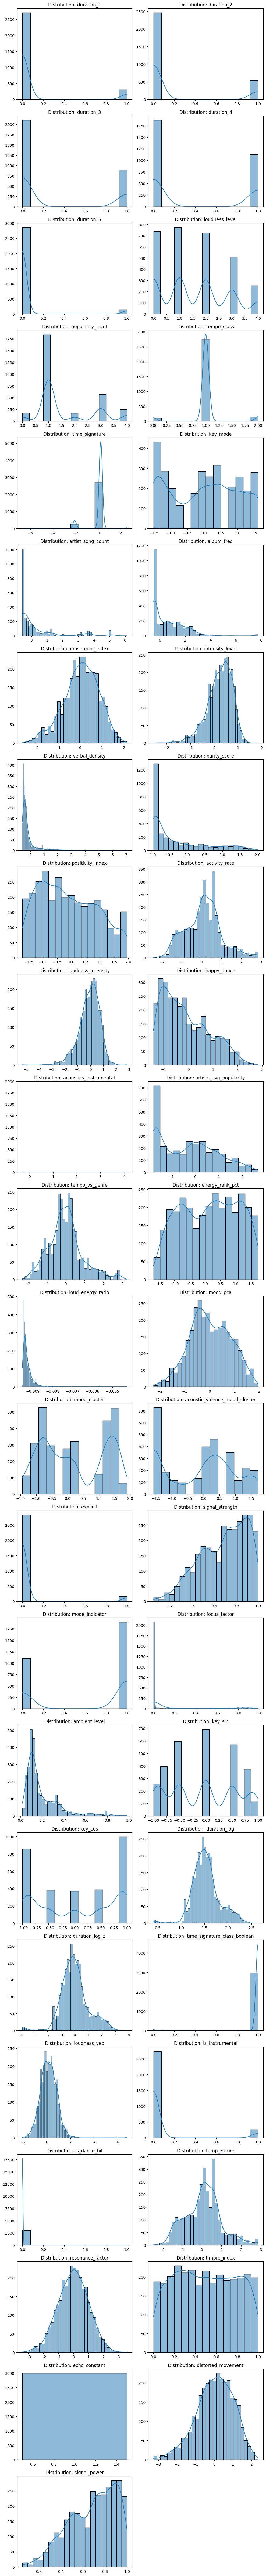

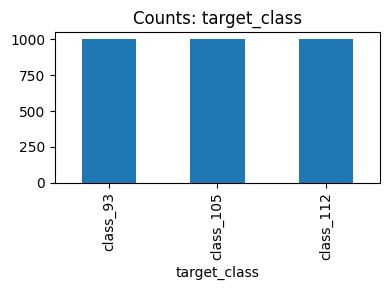

In [4]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

desc_num = df[num_cols].describe().T
desc_cat = df[cat_cols].describe().T

print("Numeric summary:")
display(desc_num.head())

print("Categorical summary:")
display(desc_cat)

# === Numeric distributions ===
num_features = [c for c in num_cols if c != 'target_regression']

n_cols = 2
n_rows = math.ceil(len(num_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution: {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Remove empty subplots if any
for j in range(len(num_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# === Categorical distributions ===
for col in cat_cols:
    plt.figure(figsize=(4,3))
    df[col].value_counts(dropna=False).plot.bar()
    plt.title(f"Counts: {col}")
    plt.tight_layout()
    plt.show()

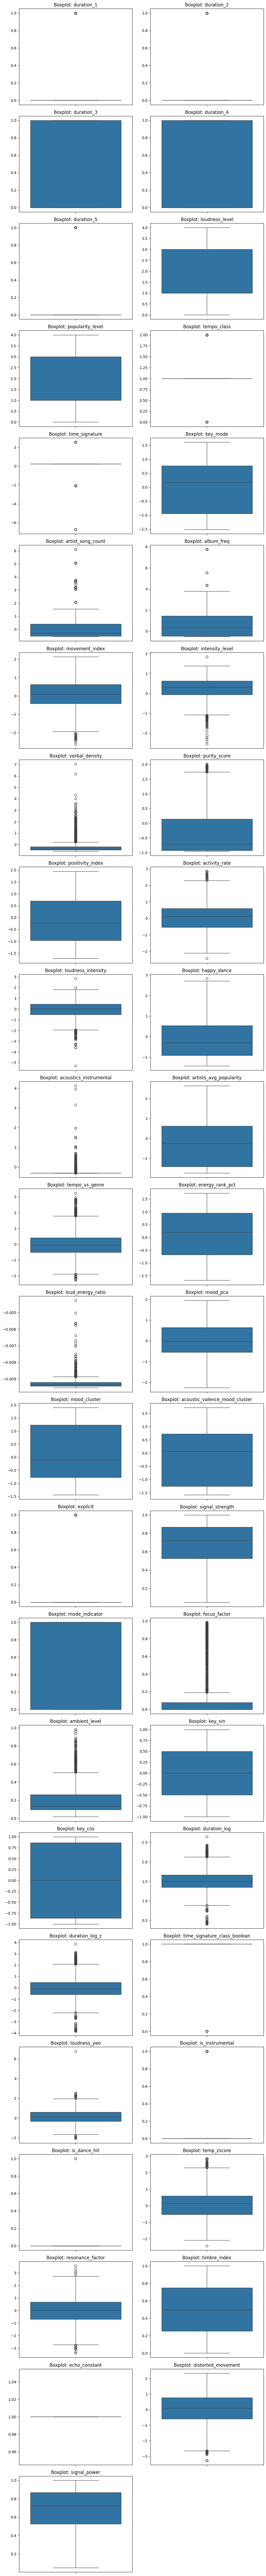

In [5]:
n_cols = 2
n_rows = math.ceil(len(num_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot: {col}")
    axes[i].set_xlabel("")  # opcional, para ficar mais limpo
    axes[i].set_ylabel("")

# Remover subplots vazios (se o número de variáveis for ímpar, etc.)
for j in range(len(num_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

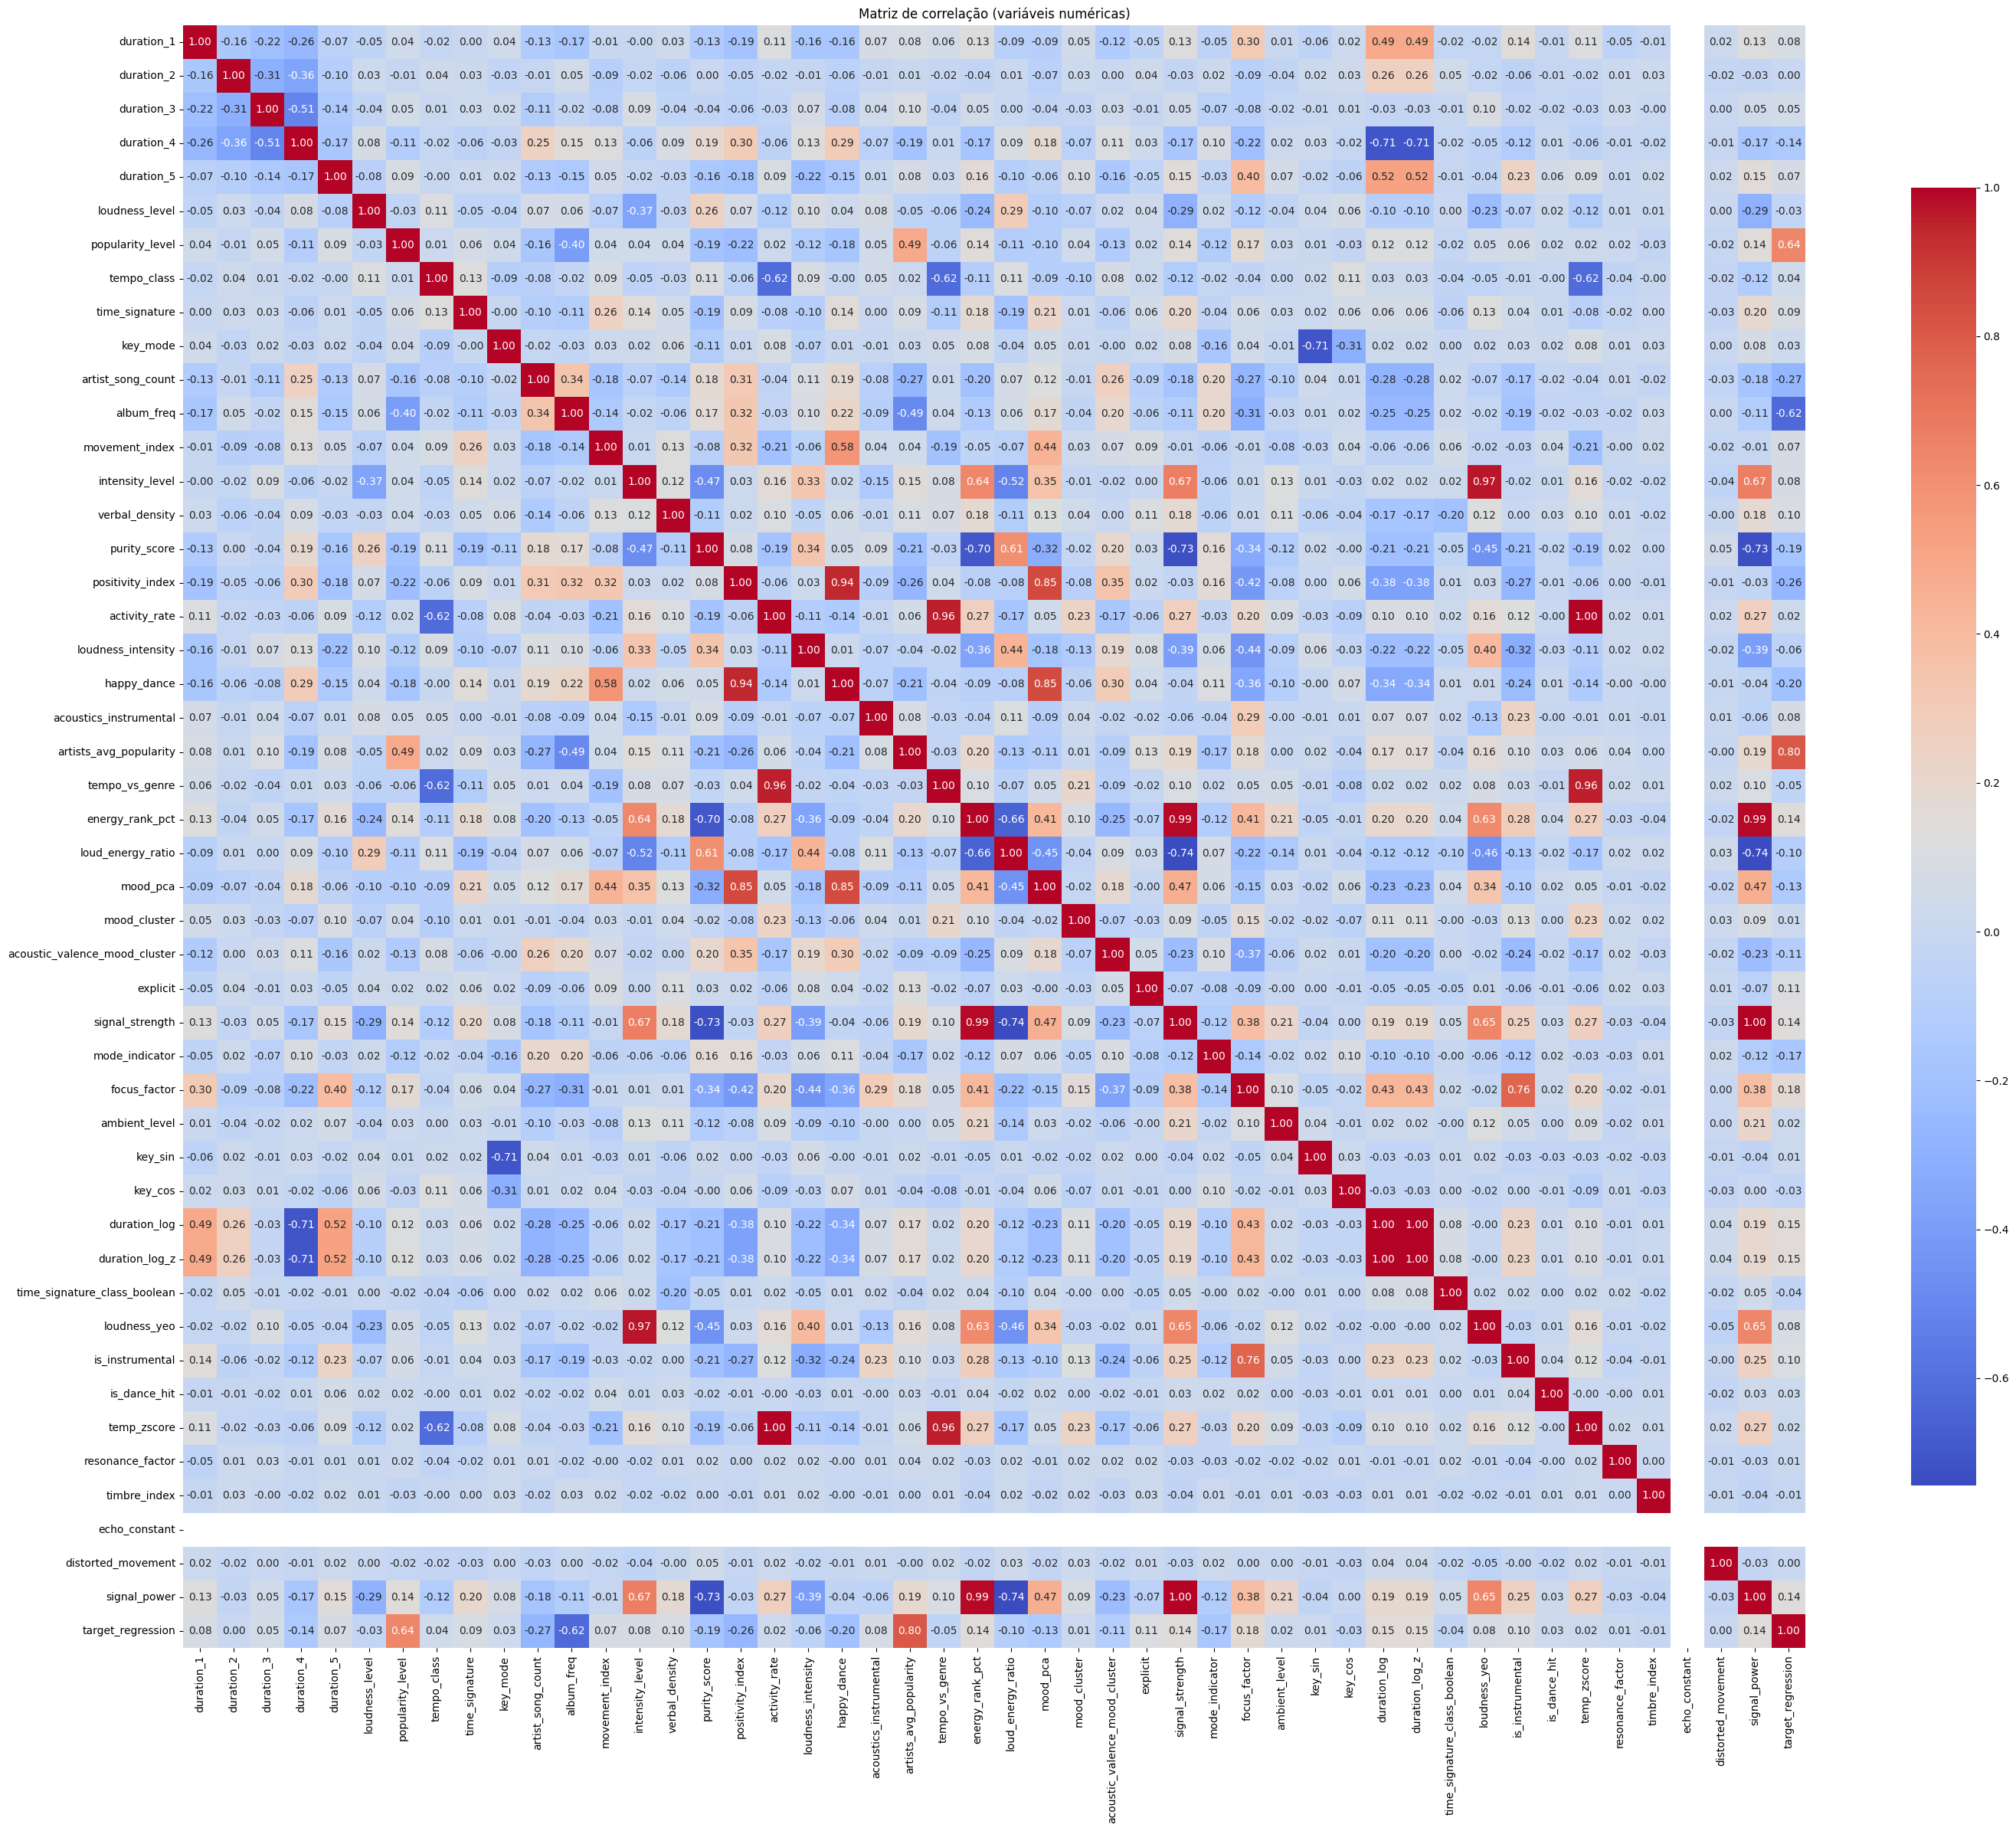

In [6]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(30, 24))
sns.heatmap(
    corr_matrix,
    annot=True,        # mostra os valores numéricos
    fmt=".2f",         # duas casas decimais
    cmap="coolwarm",   # ou outro mapa de cores que prefiras
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de correlação (variáveis numéricas)")
plt.tight_layout()
plt.show()


In [7]:
threshold = 0.95

corr_abs = corr_matrix.abs()

# 2) Considerar apenas a parte superior da matriz (sem diagonal)
mask = np.triu(np.ones(corr_abs.shape), k=1).astype(bool)
corr_upper = corr_abs.where(mask)

# 3) Obter pares com correlação > 0.95 em valor absoluto
high_corr = (
    corr_upper
    .stack()  # transforma em Series com MultiIndex (var1, var2)
    .reset_index()
)
high_corr.columns = ["var1", "var2", "corr_abs"]

high_corr = high_corr[high_corr["corr_abs"] > threshold] \
    .sort_values("corr_abs", ascending=False)

print("Pares de variáveis com |correlação| > 0.95:")
display(high_corr)

# 4) Lista de variáveis que participam em pelo menos um par com |corr| > 0.95
vars_high_corr = sorted(set(high_corr["var1"]).union(set(high_corr["var2"])))
print("Variáveis com correlação (em módulo) > 0.95 com alguma outra variável:")
print(vars_high_corr)

Pares de variáveis com |correlação| > 0.95:


var1             var2  corr_abs
943   signal_strength     signal_power  1.000000
669     activity_rate      temp_zscore  1.000000
1015     duration_log   duration_log_z  1.000000
810   energy_rank_pct  signal_strength  0.986598
826   energy_rank_pct     signal_power  0.986598
544   intensity_level     loudness_yeo  0.969534
799    tempo_vs_genre      temp_zscore  0.958444
650     activity_rate   tempo_vs_genre  0.958444

Variáveis com correlação (em módulo) > 0.95 com alguma outra variável:
['activity_rate', 'duration_log', 'duration_log_z', 'energy_rank_pct', 'intensity_level', 'loudness_yeo', 'signal_power', 'signal_strength', 'temp_zscore', 'tempo_vs_genre']


In [8]:
# Lista de variáveis a descartar (com |corr| > 0.95 em relação a outras)
to_drop = [
    "signal_power",
    "energy_rank_pct",
    "temp_zscore",
    "tempo_vs_genre",
    "duration_log_z",
    "loudness_yeo",
    "echo_constant"
]


# Se quiseres, podes sobrescrever o df original:
df = df.drop(columns=to_drop)

# Atualizar lista de variáveis numéricas (se já tinhas num_cols definido)
num_cols = df.select_dtypes(include="number").columns.tolist()
print("Número de variáveis numéricas após remoção:", len(num_cols))

Número de variáveis numéricas após remoção: 41


duration_1  duration_2  duration_3  duration_4  \
duration_1                          1.000      -0.155      -0.216      -0.257   
duration_2                         -0.155       1.000      -0.306      -0.364   
duration_3                         -0.216      -0.306       1.000      -0.507   
duration_4                         -0.257      -0.364      -0.507       1.000   
duration_5                         -0.073      -0.104      -0.144      -0.172   
loudness_level                     -0.046       0.031      -0.038       0.075   
popularity_level                    0.042      -0.013       0.054      -0.106   
tempo_class                        -0.022       0.038       0.006      -0.020   
time_signature                      0.005       0.025       0.031      -0.057   
key_mode                            0.044      -0.034       0.022      -0.028   
artist_song_count                  -0.131      -0.013      -0.115       0.255   
album_freq                         -0.165       0.051      -0.024       0.148   
movement_index                     -0.006      -0.094      -0.083       0.134   
intensity_level                    -0.003      -0.016       0.090      -0.063   
verbal_density                      0.031      -0.064      -0.043       0.086   
purity_score                       -0.129       0.001      -0.042       0.187   
positivity_index                   -0.190      -0.053      -0.064       0.298   
activity_rate                       0.110      -0.019      -0.034      -0.060   
loudness_intensity                 -0.159      -0.011       0.071       0.133   
happy_dance                        -0.165      -0.065      -0.082       0.294   
acoustics_instrumental              0.072      -0.015       0.039      -0.074   
artists_avg_popularity              0.083       0.010       0.102      -0.189   
loud_energy_ratio                  -0.088       0.008       0.002       0.089   
mood_pca                           -0.090      -0.074      -0.043       0.182   
mood_cluster                        0.047       0.030      -0.025      -0.071   
acoustic_valence_mood_cluster      -0.125       0.002       0.035       0.111   
explicit                           -0.047       0.037      -0.010       0.029   
signal_strength                     0.129      -0.028       0.050      -0.169   
mode_indicator                     -0.051       0.023      -0.073       0.096   
focus_factor                        0.305      -0.089      -0.078      -0.217   
ambient_level                       0.009      -0.040      -0.022       0.018   
key_sin                            -0.055       0.021      -0.008       0.032   
key_cos                             0.016       0.033       0.007      -0.016   
duration_log                        0.491       0.257      -0.026      -0.710   
time_signature_class_boolean       -0.021       0.048      -0.005      -0.016   
is_instrumental                     0.142      -0.060      -0.023      -0.120   
is_dance_hit                       -0.009      -0.012      -0.017       0.007   
resonance_factor                   -0.051       0.013       0.027      -0.009   
timbre_index                       -0.014       0.027      -0.001      -0.021   
distorted_movement                  0.020      -0.017       0.003      -0.012   
target_regression                   0.084       0.004       0.055      -0.139   

                               duration_5  loudness_level  popularity_level  \
duration_1                         -0.073          -0.046             0.042   
duration_2                         -0.104           0.031            -0.013   
duration_3                         -0.144          -0.038             0.054   
duration_4                         -0.172           0.075            -0.106   
duration_5                          1.000          -0.081             0.092   
loudness_level                     -0.081           1.000            -0.030   
popularity_level                    0.092          -0.030             1.000

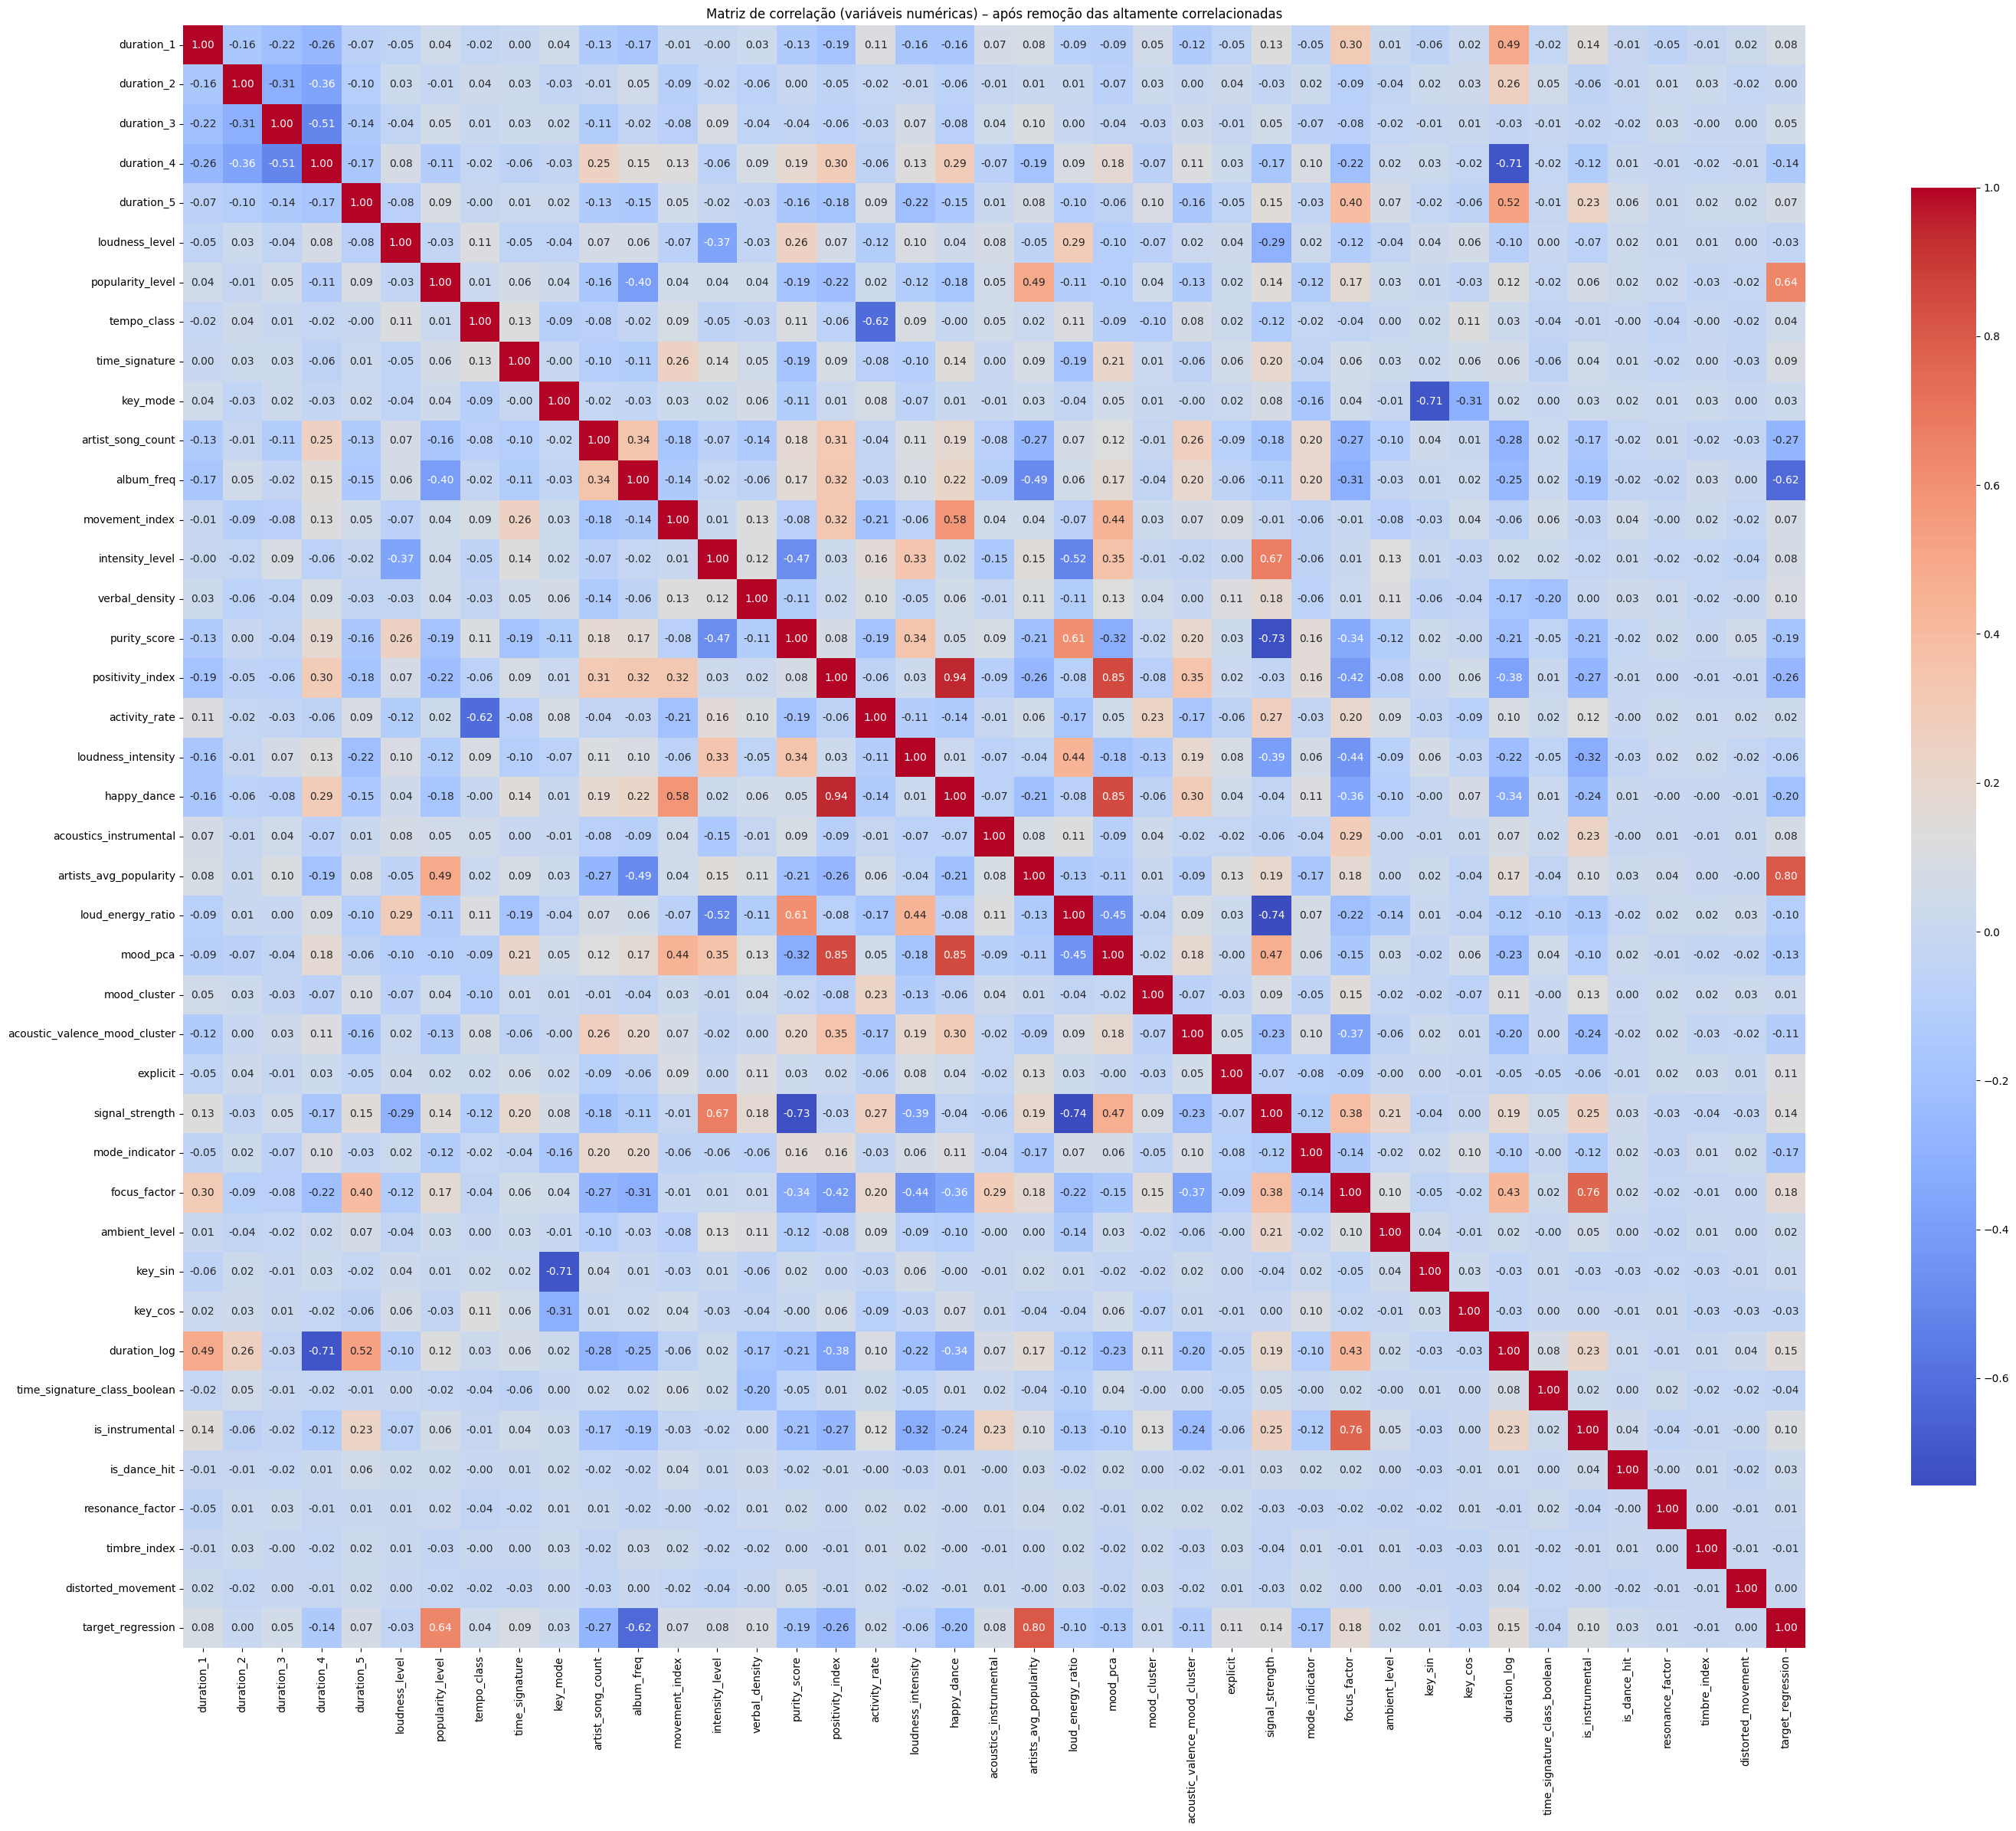

In [9]:
# Recalcular matriz de correlação com o df já limpo
corr_matrix = df[num_cols].corr(method="pearson")

# Visualizar (se quiseres ver em tabela)
display(corr_matrix.round(3))

# Heatmap atualizado
plt.figure(figsize=(30, 24))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de correlação (variáveis numéricas) – após remoção das altamente correlacionadas")
plt.tight_layout()
plt.show()


## Seleção de Features com Regularização LASSO (L1)

Nesta etapa, é aplicada uma abordagem de **seleção de features baseada em regularização**, recorrendo à Regressão Logística com penalização **L1 (LASSO)**. O principal objetivo é avaliar se a utilização de um subconjunto reduzido de variáveis permite obter modelos de classificação mais simples, interpretáveis e com desempenho competitivo.

### Preparação dos dados

Inicialmente, é criada uma cópia do conjunto de dados para evitar alterações irreversíveis. A variável `target_class` é definida como variável alvo da tarefa de classificação, sendo removidas eventuais instâncias com valores em falta nesta coluna. Apenas variáveis **numéricas** são consideradas como *features*, uma vez que a Regressão Logística requer dados quantitativos.

Antes do treino do modelo, é efetuada uma verificação da existência de valores em falta nas variáveis explicativas, o que justifica a inclusão de uma etapa de imputação no processo de aprendizagem.

### Divisão dos dados

O conjunto de dados é dividido em subconjuntos de treino e teste, utilizando uma proporção de 70% para treino e 30% para teste. A opção de **estratificação** garante que a distribuição das classes é preservada em ambos os conjuntos, assegurando uma avaliação mais justa do desempenho do modelo.

### Pipeline de aprendizagem

Para garantir um fluxo de processamento consistente e reprodutível, é utilizado um *pipeline* que integra as seguintes etapas:

- **Imputação de valores em falta**, utilizando a mediana;
- **Normalização das variáveis**, através de *Standard Scaling*;
- **Regressão Logística com penalização L1 (LASSO)**.

A regularização L1 introduz uma penalização que pode reduzir alguns coeficientes do modelo exatamente a zero, funcionando assim como um mecanismo automático de **seleção de features**.

### Ajuste do hiperparâmetro de regularização

O impacto da regularização é controlado através do hiperparâmetro `C`, que define a intensidade da penalização aplicada aos coeficientes do modelo. Foram testados vários valores de `C`, desde valores baixos (regularização forte) até valores mais elevados (regularização fraca), permitindo analisar o compromisso entre complexidade do modelo e desempenho preditivo.

Para cada valor de `C`, o modelo é treinado no conjunto de treino e avaliado no conjunto de teste, utilizando a métrica **accuracy**. O modelo com melhor desempenho é selecionado como o modelo final.

### Objetivo da abordagem

A aplicação do LASSO nesta fase do trabalho permite:

- Identificar automaticamente as **features mais relevantes** para a tarefa de classificação;
- Reduzir a dimensionalidade do conjunto de dados;
- Mitigar problemas de multicolinearidade;
- Melhorar a interpretabilidade dos modelos;
- Avaliar se modelos mais simples conseguem manter ou melhorar o desempenho preditivo;

In [10]:
from sklearn.pipeline import Pipeline

data = df.copy()

target_col = "target_class"   

data = data.dropna(subset=[target_col])

num_cols = data.select_dtypes(include="number").columns.tolist()

feature_cols = [c for c in num_cols if c != target_col]

X = data[feature_cols]
y = data[target_col]

print("Features usadas no LASSO:")
print(feature_cols)

print("\nNº de NaN por variável (antes da imputação):")
print(X.isna().sum()[X.isna().sum() > 0])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

C_values = [0.001, 0.01, 0.1, 0.3, 0.6, 0.8, 1, 2, 4, 6, 8, 10]

best_acc = -np.inf
best_C = None
best_model = None

for C in C_values:
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),  # trata NaN
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            penalty="l1",
            C=C,
            solver="liblinear",  # suporta L1
            max_iter=1000,
            random_state=42
        ))
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"C = {C}: accuracy = {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_C = C
        best_model = pipe

print("\nMelhor C encontrado:", best_C)
print(f"Melhor accuracy no conjunto de teste: {best_acc:.4f}")


Features usadas no LASSO:
['duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5', 'loudness_level', 'popularity_level', 'tempo_class', 'time_signature', 'key_mode', 'artist_song_count', 'album_freq', 'movement_index', 'intensity_level', 'verbal_density', 'purity_score', 'positivity_index', 'activity_rate', 'loudness_intensity', 'happy_dance', 'acoustics_instrumental', 'artists_avg_popularity', 'loud_energy_ratio', 'mood_pca', 'mood_cluster', 'acoustic_valence_mood_cluster', 'explicit', 'signal_strength', 'mode_indicator', 'focus_factor', 'ambient_level', 'key_sin', 'key_cos', 'duration_log', 'time_signature_class_boolean', 'is_instrumental', 'is_dance_hit', 'resonance_factor', 'timbre_index', 'distorted_movement', 'target_regression']

Nº de NaN por variável (antes da imputação):
focus_factor    10
dtype: int64
C = 0.001: accuracy = 0.3333
C = 0.01: accuracy = 0.7278
C = 0.1: accuracy = 0.7844
C = 0.3: accuracy = 0.7811
C = 0.6: accuracy = 0.7833
C = 0.8: accuracy = 0.78

A aplicação da Regressão Logística com regularização **L1 (LASSO)** permitiu avaliar o impacto da penalização na seleção de *features* e no desempenho do modelo de classificação.

Os resultados mostram que valores muito baixos de `C` (regularização forte) conduzem a um desempenho significativamente inferior, indicando um cenário de **underfitting**. À medida que o valor de `C` aumenta, observa-se uma melhoria substancial da *accuracy*, atingindo o melhor desempenho para `C = 0.1`, com uma *accuracy* de aproximadamente **0.78** no conjunto de teste.

Para valores de `C` superiores a 0.1, o desempenho mantém-se relativamente estável, sem ganhos significativos, sugerindo que a inclusão de um maior número de *features* não contribui de forma relevante para a melhoria do modelo. Este comportamento indica a existência de um subconjunto de variáveis suficientemente informativo para a tarefa de classificação.

De um modo geral, estes resultados demonstram que a regularização LASSO permite obter um bom compromisso entre **simplicidade do modelo** e **desempenho preditivo**, reforçando a importância da seleção de *features* como etapa fundamental no processo de aprendizagem automática.

In [11]:
#2) Features com coeficiente ≠ 0 e remoção das restantes

logreg = best_model.named_steps["logreg"]

# Coeficientes: shape (n_classes, n_features)
coefs = logreg.coef_

# Para problema multiclasse:
# uma feature é mantida se tiver coeficiente ≠ 0 em pelo menos uma classe
non_zero_mask = (coefs != 0).any(axis=0)

selected_features = np.array(feature_cols)[non_zero_mask].tolist()
dropped_features = np.array(feature_cols)[~non_zero_mask].tolist()

print("\nFeatures selecionadas (coeficiente ≠ 0):")
print(selected_features)

print("\nFeatures removidas pelo LASSO (coeficiente = 0):")
print(dropped_features)

# Criar novo DataFrame apenas com as features selecionadas + target
df_lasso = data[selected_features + [target_col]].copy()

print("\nDimensões originais:", data.shape)
print("Dimensões após LASSO:", df_lasso.shape)


Features selecionadas (coeficiente ≠ 0):
['duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5', 'loudness_level', 'popularity_level', 'tempo_class', 'time_signature', 'key_mode', 'artist_song_count', 'album_freq', 'movement_index', 'verbal_density', 'purity_score', 'positivity_index', 'activity_rate', 'loudness_intensity', 'happy_dance', 'acoustics_instrumental', 'artists_avg_popularity', 'loud_energy_ratio', 'mood_cluster', 'acoustic_valence_mood_cluster', 'explicit', 'signal_strength', 'mode_indicator', 'focus_factor', 'ambient_level', 'key_sin', 'key_cos', 'duration_log', 'time_signature_class_boolean', 'resonance_factor', 'timbre_index', 'distorted_movement', 'target_regression']

Features removidas pelo LASSO (coeficiente = 0):
['intensity_level', 'mood_pca', 'is_instrumental', 'is_dance_hit']

Dimensões originais: (3000, 42)
Dimensões após LASSO: (3000, 38)


In [12]:
from pygam import LogisticGAM, s

Num problema de classificação multiclasse, cada *feature* possui um coeficiente por classe. Assim, uma *feature* é considerada relevante se apresentar um coeficiente diferente de zero em pelo menos uma das classes. Com base neste critério, são selecionadas todas as *features* com coeficientes não nulos, enquanto as restantes são consideradas irrelevantes para o modelo e removidas.

A partir deste processo, é criado um novo conjunto de dados contendo apenas as *features* selecionadas pelo LASSO, juntamente com a variável alvo. Esta redução da dimensionalidade permite obter um dataset mais compacto, mantendo apenas as variáveis com maior contributo para a tarefa de classificação.

Por fim, é efetuada uma comparação entre as dimensões do conjunto de dados original e do conjunto reduzido, evidenciando o impacto da regularização L1 na seleção de *features* e na simplificação do modelo.

### Preparação do Conjunto de Dados com Features Selecionadas

Após a seleção das *features* relevantes através do método LASSO, é construído um novo conjunto de dados contendo apenas as variáveis selecionadas e a variável alvo `target_class`.

As *features* são separadas da variável alvo, sendo `X` definido como a matriz de variáveis explicativas e `y` como o vetor de classes. Adicionalmente, são identificadas as classes presentes no conjunto de dados, informação necessária para etapas posteriores de modelação.

De seguida, é efetuada uma verificação da existência de valores inválidos (*NaN* e infinitos) nas *features* selecionadas. Esta verificação permite confirmar a qualidade dos dados após a redução da dimensionalidade e identificar a necessidade de tratamento adicional.

Por fim, é aplicada uma etapa de **imputação de valores em falta**, utilizando a mediana de cada *feature*. Este procedimento garante que o conjunto de dados final não contém valores ausentes, tornando-o adequado para a aplicação dos modelos de aprendizagem automática nas fases seguintes do trabalho.

In [13]:
feature_cols = [c for c in df_lasso.columns if c != "target_class"]

X = df_lasso[feature_cols].values
y = df_lasso["target_class"].values

classes = np.unique(y)


In [14]:
# Check NaN and Inf in df_lasso features
nan_count = np.isnan(X).sum()
inf_count = np.isinf(X).sum()

nan_count, inf_count


(10, 0)

In [15]:
imputer = SimpleImputer(strategy="median")

X_clean = imputer.fit_transform(X)


# 6. Generalized Additive Models (GAM)

Nesta secção são aplicados **Generalized Additive Models (GAM)** para tarefas de classificação binária, recorrendo exclusivamente às *features* selecionadas na etapa anterior de seleção de features.

Dado que o problema original é multiclasse, foi adotada uma estratégia **one-vs-rest**, onde, para cada classe, é treinado um modelo binário com o objetivo de distinguir essa classe das restantes.

Cada GAM é construído utilizando funções suaves (*splines*) para modelar a relação entre cada *feature* e a variável alvo, permitindo capturar **relações não lineares** sem perder interpretabilidade. O número de *splines* foi fixado de forma a equilibrar flexibilidade e risco de sobreajuste.

A avaliação dos modelos é realizada através de **validação cruzada estratificada com 5 *folds***, garantindo a preservação da distribuição das classes em cada divisão. Para cada classe são calculadas as métricas **Accuracy**, **F1-score** e **ROC-AUC**, sendo reportada a média dos resultados obtidos nos diferentes *folds*.

Esta abordagem permite avaliar a capacidade dos GAM em identificar padrões não lineares nos dados e comparar o seu desempenho com os modelos de classificação analisados nas secções anteriores.

In [16]:
def gam_cv(X, y_bin, splits=5):
    cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

    acc, f1, auc = [], [], []

    terms = s(0)
    for i in range(1, X.shape[1]):
        terms += s(i)

    for tr, te in cv.split(X, y_bin):
        gam = LogisticGAM(
            terms,
            max_iter=1000,
            n_splines=10
        )

        gam.fit(X[tr], y_bin[tr])

        y_pred = gam.predict(X[te])
        y_prob = gam.predict_proba(X[te])

        acc.append(accuracy_score(y_bin[te], y_pred))
        f1.append(f1_score(y_bin[te], y_pred))
        auc.append(roc_auc_score(y_bin[te], y_prob))

    return np.mean(acc), np.mean(f1), np.mean(auc)


In [17]:
gam_results = {}

for c in classes:
    y_binary = (y == c).astype(int)
    gam_results[c] = gam_cv(X_clean, y_binary)

pd.DataFrame(
    gam_results,
    index=["Accuracy", "F1", "ROC_AUC"]
).T


Accuracy        F1   ROC_AUC
class_105  0.865667  0.798701  0.938545
class_112  0.963667  0.945498  0.993285
class_93   0.871333  0.802899  0.933470

In [18]:
gam_df = pd.DataFrame(
    gam_results,
    index=["Accuracy", "F1", "ROC_AUC"]
).T


best_class = gam_df["ROC_AUC"].idxmax()
best_scores = gam_df.loc[best_class]

print("Melhor modelo: Classe =", best_class)
print(best_scores)


Melhor modelo: Classe = class_112
Accuracy    0.963667
F1          0.945498
ROC_AUC     0.993285
Name: class_112, dtype: float64


Os resultados médios obtidos para cada classe são apresentados de seguida:

- **class_105**  
  - Accuracy ≈ 0.87  
  - F1-score ≈ 0.80  
  - ROC-AUC ≈ 0.94  

- **class_93**  
  - Accuracy ≈ 0.87  
  - F1-score ≈ 0.80  
  - ROC-AUC ≈ 0.93  

- **class_112**  
  - Accuracy ≈ 0.96  
  - F1-score ≈ 0.95  
  - ROC-AUC ≈ 0.99  

Entre os modelos avaliados, o melhor desempenho foi obtido para a **classe class_112**, que apresentou simultaneamente os valores mais elevados de *accuracy*, *F1-score* e *ROC-AUC*. Este resultado indica que as *features* selecionadas permitem uma separação particularmente eficaz desta classe em relação às restantes.

### Analise

Os resultados demonstram que os **GAM conseguem capturar eficazmente relações não lineares** entre as *features* e a variável alvo, apresentando desempenhos elevados, especialmente para determinadas classes. A variação de desempenho entre classes sugere que algumas categorias musicais possuem padrões mais facilmente separáveis, enquanto outras apresentam maior sobreposição no espaço das *features*.

Comparativamente aos modelos lineares analisados em secções anteriores, os GAM oferecem uma maior flexibilidade, mantendo ainda assim uma estrutura interpretável, o que os torna uma alternativa interessante para problemas onde a linearidade não é garantida.

# 7. Decision Tree & Random Forest

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_clean,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42
)


## 7.1. Decision Tree

No contexto deste trabalho, as Decision Trees são aplicadas à tarefa de classificação multiclasse, utilizando as *features* selecionadas na etapa anterior de seleção de features. Esta abordagem permite avaliar o desempenho do modelo com um conjunto reduzido de variáveis, mitigando problemas de multicolinearidade e melhorando a interpretabilidade.

Inicialmente, é treinado um modelo de Decision Tree **sem otimização de hiperparâmetros**, com o objetivo de estabelecer um *baseline* de desempenho. Posteriormente, é realizada uma etapa de **ajuste de hiperparâmetros**, recorrendo a validação cruzada, de forma a controlar a complexidade do modelo e reduzir o risco de sobreajuste.

O desempenho dos modelos é avaliado através de métricas adequadas a problemas multiclasse, nomeadamente o **F1-score ponderado**, permitindo uma comparação consistente entre as diferentes configurações testadas.

In [21]:
dt_full = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    random_state=42
)

dt_full.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [22]:
cv_scores_full = cross_val_score(
    dt_full,
    X_train,
    y_train,
    cv=5,
    scoring="f1_weighted"
)

cv_scores_full.mean(), cv_scores_full.std()


(0.8352905700340006, 0.010304527334450862)

In [23]:
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [2, 4, 6, 8, 10, 12, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8]
}

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

best_dt = grid.best_estimator_

y_pred = best_dt.predict(X_test)

print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.8417313736438821

Test Set Performance:
              precision    recall  f1-score   support

   class_105       0.80      0.86      0.83       300
   class_112       0.91      0.88      0.89       300
    class_93       0.84      0.81      0.82       300

    accuracy                           0.85       900
   macro avg       0.85      0.85      0.85       900
weighted avg       0.85      0.85      0.85       900


Confusion Matrix:
[[258  15  27]
 [ 17 264  19]
 [ 47  11 242]]


O ajuste de hiperparâmetros foi realizado recorrendo ao método **GridSearchCV**, utilizando validação cruzada estratificada com 5 *folds*. Foram testadas diferentes combinações dos seguintes hiperparâmetros:

- `criterion`: método de cálculo da impureza do nó (`gini`, `entropy`, `log_loss`);
- `max_depth`: profundidade máxima da árvore;
- `min_samples_split`: número mínimo de amostras necessárias para dividir um nó;
- `min_samples_leaf`: número mínimo de amostras numa folha.

Como métrica de avaliação foi utilizado o **F1-score ponderado**, adequado para problemas multiclasse e robusto a eventuais desequilíbrios entre classes.

A melhor configuração encontrada foi:

- `criterion = gini`
- `max_depth = 10`
- `min_samples_split = 2`
- `min_samples_leaf = 1`

Esta configuração permitiu obter um **F1-score médio em validação cruzada de aproximadamente 0.84**, indicando um bom equilíbrio entre desempenho e complexidade do modelo.


In [24]:
best_dt = DecisionTreeClassifier(
    max_depth=10,
    criterion="gini",
    random_state=42,
    min_samples_leaf=1,
    min_samples_split=2
)

best_dt.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=10, random_state=42)

In [25]:
print(classification_report(
    y_test,
    best_dt.predict(X_test)
))


              precision    recall  f1-score   support

   class_105       0.80      0.86      0.83       300
   class_112       0.91      0.88      0.89       300
    class_93       0.84      0.81      0.82       300

    accuracy                           0.85       900
   macro avg       0.85      0.85      0.85       900
weighted avg       0.85      0.85      0.85       900



## 7.2. Random Forest

O **Random Forest** é um método de *ensemble learning* baseado na combinação de múltiplas Decision Trees, treinadas sobre diferentes subconjuntos dos dados e das *features*. Ao agregar as previsões de várias árvores, este modelo reduz significativamente o risco de sobreajuste e melhora a capacidade de generalização, quando comparado com uma única árvore de decisão. Nesta secção, o Random Forest é aplicado à tarefa de classificação multiclasse, utilizando as *features* selecionadas na etapa de seleção de features. O desempenho do modelo é avaliado inicialmente através de uma configuração base (*baseline*), seguindo-se um processo de otimização de hiperparâmetros e uma análise da importância das *features*.

Numa primeira fase, é treinado um modelo base de Random Forest, utilizando um número fixo de árvores e os valores por defeito dos restantes hiperparâmetros. Esta abordagem permite estabelecer um ponto de referência (*baseline*) para o desempenho do modelo, antes da aplicação de técnicas de otimização.

O desempenho é avaliado recorrendo a **validação cruzada com 5 folds**, utilizando a métrica **F1-score ponderado**, adequada para problemas de classificação multiclasse.


In [26]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_features="sqrt",
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)


In [27]:
cv_scores_rf = cross_val_score(
    rf,
    X_train,
    y_train,
    cv=5,
    scoring="f1_weighted"
)
print("Baseline")
cv_scores_rf.mean(), cv_scores_rf.std()


Baseline


(0.9055244589713753, 0.011594448110341195)

In [28]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

### Avaliação do Modelo Base no Conjunto de Teste

Após o treino do modelo base, procede-se à sua avaliação num conjunto de teste independente. Esta análise permite observar o desempenho do Random Forest em dados não vistos, através de métricas como *precision*, *recall* e *F1-score* para cada classe.

Os resultados obtidos fornecem uma primeira indicação da capacidade do Random Forest em capturar padrões relevantes nos dados, servindo de referência para a etapa de otimização de hiperparâmetros.

In [29]:
print(classification_report(
    y_test,
    rf.predict(X_test)
))


              precision    recall  f1-score   support

   class_105       0.86      0.91      0.88       300
   class_112       0.97      0.97      0.97       300
    class_93       0.91      0.86      0.89       300

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900



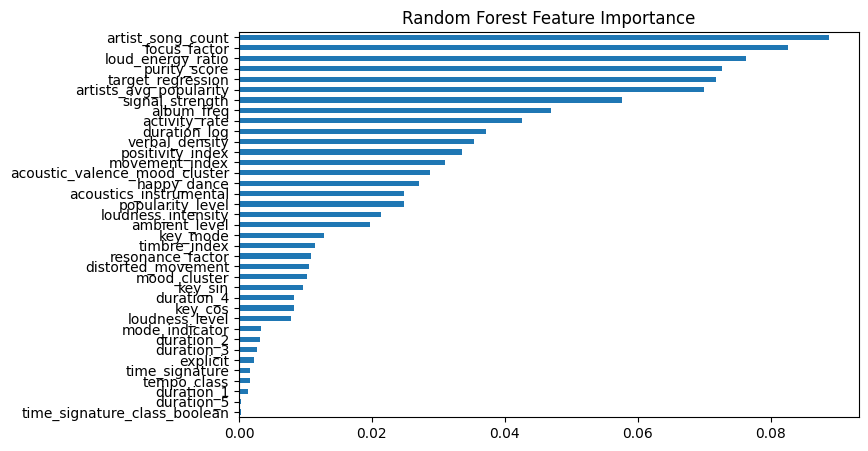

In [30]:
importances = pd.Series(
    rf.feature_importances_,
    index=feature_cols
).sort_values(ascending=True)

importances.plot(kind="barh", figsize=(8,5))
plt.title("Random Forest Feature Importance")
plt.show()


### Otimização de Hiperparâmetros do Random Forest

Com o objetivo de melhorar o desempenho do modelo e controlar a sua complexidade, é realizada uma etapa de **otimização de hiperparâmetros**, recorrendo ao método **GridSearchCV** com validação cruzada estratificada.

Foram exploradas diferentes combinações dos seguintes hiperparâmetros:

- `n_estimators`: número de árvores na floresta;
- `max_depth`: profundidade máxima das árvores;
- `min_samples_split`: número mínimo de amostras para dividir um nó;
- `min_samples_leaf`: número mínimo de amostras numa folha;
- `max_features`: número de *features* consideradas em cada divisão.

A métrica utilizada para a seleção do melhor modelo foi o **F1-score ponderado**.

In [31]:
param_grid_rf = {
    "n_estimators": [300, 500, 800],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid_rf,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best Hyperparameters:", grid_rf.best_params_)
print("Best CV F1-weighted Score:", grid_rf.best_score_)


Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
Best CV F1-weighted Score: 0.9098726138811019


### Refinamento Progressivo da Pesquisa de Hiperparâmetros

Após a identificação de uma região promissora no espaço de hiperparâmetros, foi realizado um refinamento progressivo da grelha de pesquisa. Este procedimento permitiu concentrar a análise em valores mais específicos, reduzindo o custo computacional e ajustando de forma mais precisa os parâmetros do modelo.

Este processo iterativo contribuiu para a obtenção de uma configuração final do Random Forest com melhor compromisso entre desempenho e complexidade.

In [32]:
param_grid_rf = {
    "n_estimators": [700,800, 900, 1000],
    "max_depth": [None, 10, 20],
    "min_samples_split": [1,2, 3, 4],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["log2"]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid_rf,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best Hyperparameters:", grid_rf.best_params_)
print("Best CV F1-weighted Score:", grid_rf.best_score_)


Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 800}
Best CV F1-weighted Score: 0.911776897585321


In [33]:
param_grid_rf = {
    "n_estimators": [790,800, 810, 820, 830],
    "max_depth": [None],
    "min_samples_split": [3],
    "min_samples_leaf": [1],
    "max_features": ["log2"]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid_rf,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best Hyperparameters:", grid_rf.best_params_)
print("Best CV F1-weighted Score:", grid_rf.best_score_)


Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 790}
Best CV F1-weighted Score: 0.9117879845272817


In [34]:
param_grid_rf = {
    "n_estimators": [770,780,790,795],
    "max_depth": [None],
    "min_samples_split": [3],
    "min_samples_leaf": [1],
    "max_features": ["log2"]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid_rf,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best Hyperparameters:", grid_rf.best_params_)
print("Best CV F1-weighted Score:", grid_rf.best_score_)


Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 790}
Best CV F1-weighted Score: 0.9117879845272817


### Avaliação do Modelo Otimizado

In [35]:
rf_best = RandomForestClassifier(
    n_estimators=790,
    max_features="log2",
    bootstrap=True,
    random_state=42,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=3,
    n_jobs=-1
)


In [36]:
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', min_samples_split=3,
                       n_estimators=790, n_jobs=-1, random_state=42)

In [37]:
print(classification_report(
    y_test,
    rf_best.predict(X_test)
))


              precision    recall  f1-score   support

   class_105       0.86      0.90      0.88       300
   class_112       0.96      0.97      0.97       300
    class_93       0.91      0.87      0.89       300

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900



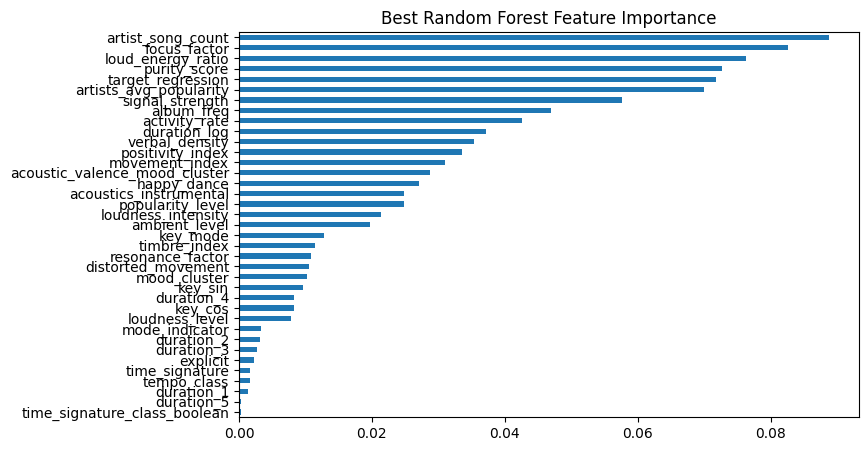

In [38]:
best_importances = pd.Series(
    rf_best.feature_importances_,
    index=feature_cols
).sort_values(ascending=True)

importances.plot(kind="barh", figsize=(8,5))
plt.title("Best Random Forest Feature Importance")
plt.show()


# 8. Support Vector Machines (SVM)

Numa primeira fase, foram aplicados modelos Support Vector Machine (SVM) com diferentes funções kernel, sem qualquer otimização de hiperparâmetros, com o objetivo de avaliar o impacto da escolha do kernel no desempenho do classificador.

Foram considerados os seguintes kernels:

- Linear
- Polinomial (poly)
- Radial Basis Function (RBF)
- Sigmoid

Para cada kernel, o modelo foi treinado com o conjunto de treino e avaliado no conjunto de teste, utilizando a métrica F1-score ponderado (weighted F1-score), adequada a problemas com classes desbalanceadas.

In [39]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report


In [40]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
baseline_results = []

print("Baseline SVM Models:\n")

for k in kernels:
    svm = SVC(kernel=k)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    test_f1 = f1_score(y_test, y_pred, average="weighted")
    baseline_results.append([k, test_f1])

    print(f"\nKernel: {k}")
    print(classification_report(y_test, y_pred))

baseline_df = pd.DataFrame(baseline_results,
    columns=["Kernel", "Test_F1_weighted"]
)
print("\nBaseline Kernel Performance:\n")
print(baseline_df)


Baseline SVM Models:


Kernel: linear
              precision    recall  f1-score   support

   class_105       0.72      0.79      0.75       300
   class_112       0.87      0.89      0.88       300
    class_93       0.76      0.66      0.71       300

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.78      0.78      0.78       900


Kernel: poly
              precision    recall  f1-score   support

   class_105       0.79      0.85      0.82       300
   class_112       0.92      0.95      0.94       300
    class_93       0.86      0.77      0.82       300

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86       900
weighted avg       0.86      0.86      0.86       900


Kernel: rbf
              precision    recall  f1-score   support

   class_105       0.79      0.83      0.81       300
   class_112       0.92      0.94      0.93       300
    class_

Após a avaliação inicial dos diferentes kernels, procedeu-se à otimização de hiperparâmetros para cada tipo de kernel SVM, com o objetivo de identificar a configuração que maximiza o desempenho do modelo. Para garantir uma avaliação robusta e adequada a datasets desbalanceados, foi utilizada Stratified K-Fold Cross-Validation com 5 folds, assegurando que a distribuição das classes é mantida em cada partição.

Foram definidos grelhas de hiperparâmetros específicas para cada kernel, tendo em conta as suas características:
- **Kernel Linear**
    - Parâmetro de regularização: C
- **Kernel RBF**
    - Parâmetros: C e gamma
- **Kernel Polinomial**
    - Parâmetros: C, gamma e degree
- **Kernel Sigmoid**
    - Parâmetros: C e gamma

Esta abordagem permite adaptar o processo de otimização ao comportamento específico de cada kernel, evitando combinações irrelevantes.

A otimização foi realizada através do método GridSearchCV, testando exaustivamente todas as combinações de hiperparâmetros definidas para cada kernel. Como métrica de avaliação foi utilizado o **F1-score ponderado** (weighted F1-score), por ser adequado a problemas com classes desbalanceadas e por equilibrar precisão e recall.

Para cada kernel, o processo envolveu:
- Treino do modelo com validação cruzada;
- Identificação da melhor combinação de hiperparâmetros;
- Seleção do melhor estimador com base no desempenho médio em validação cruzada.

In [41]:
#########################################################
# 2) Hyperparameter Tuning for Each Kernel
#########################################################

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    "linear": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100]
    },
    "rbf": {
        "C": [0.1, 1, 10, 100],
        "gamma": [0.01, 0.1, 0.5, 1]
    },
    "poly": {
        "C": [0.1, 1, 10],
        "gamma": [0.01, 0.1, 1],
        "degree": [2, 3, 4]
    },
    "sigmoid": {
        "C": [0.1, 1, 10],
        "gamma": [0.01, 0.1, 1]
    }
}

best_models = {}
final_results = []

print("\n### Tuning Results ###")

for kernel, params in param_grids.items():
    print(f"\nTuning kernel: {kernel}")

    svm = SVC(kernel=kernel)
    grid = GridSearchCV(
        estimator=svm,
        param_grid=params,
        scoring="f1_weighted",
        cv=inner_cv,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_models[kernel] = grid.best_estimator_

    # Overfitting check
    cv_mean = grid.best_score_
    test_f1 = f1_score(y_test, best_models[kernel].predict(X_test), average="weighted")

    final_results.append([kernel, cv_mean, test_f1])

    print("Best params:", grid.best_params_)
    print("CV-F1:", cv_mean)
    print("Test-F1:", test_f1)
    print(classification_report(y_test, best_models[kernel].predict(X_test)))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, best_models[kernel].predict(X_test)))


### Tuning Results ###

Tuning kernel: linear
Best params: {'C': 1}
CV-F1: 0.7952146437491725
Test-F1: 0.7785832146251294
              precision    recall  f1-score   support

   class_105       0.72      0.79      0.75       300
   class_112       0.87      0.89      0.88       300
    class_93       0.76      0.66      0.71       300

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.78      0.78      0.78       900

Confusion Matrix:
[[237  18  45]
 [ 15 266  19]
 [ 78  23 199]]

Tuning kernel: rbf
Best params: {'C': 10, 'gamma': 0.1}
CV-F1: 0.8684150445695155
Test-F1: 0.8636589214477004
              precision    recall  f1-score   support

   class_105       0.82      0.82      0.82       300
   class_112       0.94      0.92      0.93       300
    class_93       0.83      0.84      0.83       300

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86      

Após a otimização de hiperparâmetros para cada kernel, procedeu-se à comparação do desempenho dos modelos com base no F1-score ponderado, tanto em validação cruzada como no conjunto de teste.

A Tabela seguinte resume os principais resultados obtidos:

**Kernel Linear**

- CV F1 ≈ 0.80

- Test F1 ≈ 0.78

**Kernel RBF**

- CV F1 ≈ 0.86

- Test F1 ≈ 0.86

**Kernel Polinomial**

- CV F1 ≈ 0.86

- Test F1 ≈ 0.86

**Kernel Sigmoid**

- CV F1 ≈ 0.75

- Test F1 ≈ 0.73

Após a identificação das regiões mais promissoras do espaço de hiperparâmetros na fase inicial de otimização, foram realizadas sucessivos micro ajustos até se atingir os parametros ótimos.

Esta abordagem permite explorar valores mais próximos do ótimo, reduzindo o risco de saltar soluções subótimas devido a grelhas demasiado largas.

Com base nos melhores resultados obtidos anteriormente, foram definidos espaços de pesquisa mais restritos e centrados em torno dos valores ótimos, específicos para cada kernel:

**Kernel Linear**

- Valores de C próximos da região ótima previamente identificada

**Kernel RBF**

- Ajuste fino dos parâmetros C e gamma, focando valores intermédios

**Kernel Polinomial**

- Exploração de graus fracionários e valores reduzidos de C, visando melhor generalização

**Kernel Sigmoid**

- Ajuste simultâneo de C e gamma, mantendo uma grelha mais contida

Esta estratégia reduz o custo computacional e aumenta a probabilidade de encontrar soluções mais estáveis.

In [42]:
#########################################################
# 2) Hyperparameter Tuning for Each Kernel
#########################################################

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    "linear": {
        "C": [0.8, 0.85, 0.9, 1, 1.1, 1.2]
    },
    "rbf": {
        "C": [7, 8, 9, 10, 11, 12],
        "gamma": [0.08, 0.09, 0.1, 0.11, 0.12]
    },
    "poly": {
        "C": [0.05, 0.1, 0.15, 0.2],
        "gamma": [0.01, 0.1, 1],
        "degree": [2.5, 3, 3.5]
    },
    "sigmoid": {
        "C": [0.5, 1, 2, 3],
        "gamma": [0.01, 0.02, 0.03]
    }
}

best_models = {}
final_results = []

print("\n### Tuning Results ###")

for kernel, params in param_grids.items():
    print(f"\nTuning kernel: {kernel}")

    svm = SVC(kernel=kernel)
    grid = GridSearchCV(
        estimator=svm,
        param_grid=params,
        scoring="f1_weighted",
        cv=inner_cv,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_models[kernel] = grid.best_estimator_

    # Overfitting check
    cv_mean = grid.best_score_
    test_f1 = f1_score(y_test, best_models[kernel].predict(X_test), average="weighted")

    final_results.append([kernel, cv_mean, test_f1])

    print("Best params:", grid.best_params_)
    print("CV-F1:", cv_mean)
    print("Test-F1:", test_f1)
    print(classification_report(y_test, best_models[kernel].predict(X_test)))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, best_models[kernel].predict(X_test)))



### Tuning Results ###

Tuning kernel: linear
Best params: {'C': 1.1}
CV-F1: 0.7966215103255864
Test-F1: 0.7785832146251294
              precision    recall  f1-score   support

   class_105       0.72      0.79      0.75       300
   class_112       0.87      0.89      0.88       300
    class_93       0.76      0.66      0.71       300

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.78      0.78      0.78       900

Confusion Matrix:
[[237  18  45]
 [ 15 266  19]
 [ 78  23 199]]

Tuning kernel: rbf
Best params: {'C': 7, 'gamma': 0.08}
CV-F1: 0.8701955355414416
Test-F1: 0.8558111224696406
              precision    recall  f1-score   support

   class_105       0.81      0.82      0.82       300
   class_112       0.94      0.93      0.93       300
    class_93       0.82      0.82      0.82       300

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86    

In [43]:
#########################################################
# 2) Hyperparameter Tuning for Each Kernel
#########################################################

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    "linear": {
        "C": [1, 1.05, 1.1]
    },
    "rbf": {
        "C": [4, 5, 6, 7],
        "gamma": [0.05, 0.06, 0.07,0.08]
    },
    "poly": {
        "C": [0.1],
        "gamma": [0.05, 0.1, 0.15, 0.2],
        "degree": [3]
    },
    "sigmoid": {
        "C": [2,2.5, 3],
        "gamma": [0.001, 0.005, 0.01, 0.02]
    }
}

best_models = {}
final_results = []

print("\n### Tuning Results ###")

for kernel, params in param_grids.items():
    print(f"\nTuning kernel: {kernel}")

    svm = SVC(kernel=kernel)
    grid = GridSearchCV(
        estimator=svm,
        param_grid=params,
        scoring="f1_weighted",
        cv=inner_cv,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_models[kernel] = grid.best_estimator_

    # Overfitting check
    cv_mean = grid.best_score_
    test_f1 = f1_score(y_test, best_models[kernel].predict(X_test), average="weighted")

    final_results.append([kernel, cv_mean, test_f1])

    print("Best params:", grid.best_params_)
    print("CV-F1:", cv_mean)
    print("Test-F1:", test_f1)
    print(classification_report(y_test, best_models[kernel].predict(X_test)))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, best_models[kernel].predict(X_test)))




### Tuning Results ###

Tuning kernel: linear
Best params: {'C': 1.1}
CV-F1: 0.7966215103255864
Test-F1: 0.7785832146251294
              precision    recall  f1-score   support

   class_105       0.72      0.79      0.75       300
   class_112       0.87      0.89      0.88       300
    class_93       0.76      0.66      0.71       300

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.78      0.78      0.78       900

Confusion Matrix:
[[237  18  45]
 [ 15 266  19]
 [ 78  23 199]]

Tuning kernel: rbf
Best params: {'C': 7, 'gamma': 0.08}
CV-F1: 0.8701955355414416
Test-F1: 0.8558111224696406
              precision    recall  f1-score   support

   class_105       0.81      0.82      0.82       300
   class_112       0.94      0.93      0.93       300
    class_93       0.82      0.82      0.82       300

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86    

In [44]:

#########################################################
# 3) Final Comparison Table
#########################################################

final_results_df = pd.DataFrame(
    final_results,
    columns=["Kernel", "CV_F1_weighted", "Test_F1_weighted"]
)

print("\n### Final Comparison of Tuned Kernels ###")
print(final_results_df)



### Final Comparison of Tuned Kernels ###
    Kernel  CV_F1_weighted  Test_F1_weighted
0   linear        0.796622          0.778583
1      rbf        0.870196          0.855811
2     poly        0.861101          0.864283
3  sigmoid        0.770012          0.749187


Após o processo completo de otimização e ajuste fino dos hiperparâmetros, foi realizada uma comparação final entre os kernels SVM, considerando o desempenho médio em validação cruzada e o desempenho no conjunto de teste.

A tabela seguinte resume os resultados obtidos, utilizando o F1-score ponderado como métrica principal:

**Kernel Linear**
- CV F1 ≈ 0.80
- Test F1 ≈ 0.79

**Kernel RBF**
- CV F1 ≈ 0.87
- Test F1 ≈ 0.86

**Kernel Polinomial**
- CV F1 ≈ 0.86
- Test F1 ≈ 0.86

**Kernel Sigmoid**
- CV F1 ≈ 0.77
- Test F1 ≈ 0.75

In [45]:
#########################################################
# 4) Select Best SVM Model
#########################################################

# Best model based on Test performance
best_row_test = final_results_df.iloc[np.argmax(final_results_df["Test_F1_weighted"])]
best_kernel_test = best_row_test["Kernel"]
best_model_test = best_models[best_kernel_test]

# Best model based on CV performance
best_row_cv = final_results_df.iloc[np.argmax(final_results_df["CV_F1_weighted"])]
best_kernel_cv = best_row_cv["Kernel"]
best_model_cv = best_models[best_kernel_cv]


print("\n=== BEST BY TEST SET PERFORMANCE ===")
print(best_row_test)
print(f"Selected Kernel (Test): {best_kernel_test}")

print("\n=== BEST BY CROSS-VALIDATION PERFORMANCE ===")
print(best_row_cv)
print(f"Selected Kernel (CV): {best_kernel_cv}")

# Select the final SVM model based on CV performance (correct methodology)
final_svm_model = best_model_cv

print("\nFinal SVM model selected for further evaluation:")
print(final_svm_model)


=== BEST BY TEST SET PERFORMANCE ===
Kernel                  poly
CV_F1_weighted      0.861101
Test_F1_weighted    0.864283
Name: 2, dtype: object
Selected Kernel (Test): poly

=== BEST BY CROSS-VALIDATION PERFORMANCE ===
Kernel                   rbf
CV_F1_weighted      0.870196
Test_F1_weighted    0.855811
Name: 1, dtype: object
Selected Kernel (CV): rbf

Final SVM model selected for further evaluation:
SVC(C=7, gamma=0.08)


Analisando o **F1-score ponderado** no conjunto de teste, o modelo com melhor desempenho foi:

**Kernel: Polinomial**

**Test F1-score**: ≈ 0.86

Este resultado indica que o kernel polinomial apresentou a melhor performance nos dados não utilizados durante o treino, para esta divisão específica do dataset.

Considerando o** F1-score médio** obtido em **validação cruzada**, o modelo com melhor desempenho foi:

**Kernel: RBF**

**CV F1-score**: ≈ 0.87

Este resultado sugere que o kernel RBF apresenta maior estabilidade global, sendo menos dependente de uma divisão específica dos dados.

#### Critério de Seleção do Modelo Final

Para a escolha do modelo SVM final, foi adotado o critério baseado na validação cruzada, por ser metodologicamente mais correto e consistente com as boas práticas em aprendizagem automática.

Assim, apesar do kernel polinomial apresentar ligeiramente melhor desempenho no conjunto de teste, o kernel RBF foi selecionado como modelo final, devido à sua melhor capacidade de generalização estimada.

#### Modelo SVM Final Selecionado

O modelo SVM final selecionado para as etapas seguintes do trabalho é:
- Kernel: RBF

Parâmetros:
- C = 7
- gamma = 0.08

Este modelo será utilizado como referência para comparações posteriores com outros métodos de redução de dimensionalidade e seleção de características.


# 9. Principal Component Analysis (PCA)

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Antes da aplicação da PCA, os dados foram normalizados utilizando o StandardScaler uma vez que a PCA é sensível à escala das variáveis e baseia-se na variância dos dados.

A normalização garante que:
- Todas as features contribuem de forma equilibrada;
- Variáveis com maior escala não dominam as componentes principais;
- Os resultados da PCA são interpretáveis e consistentes.

In [47]:
# Standardization is mandatory for PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 9.1. PCA sem Restrição de Componentes

Numa primeira fase, foi aplicada uma PCA completa, sem restrição no número de componentes principais.
Este procedimento permite analisar a variância explicada acumulada e compreender quantas componentes são necessárias para representar a maior parte da informação presente nos dados originais.

In [48]:
pca_full = PCA()
pca_full.fit(X_train_scaled)


PCA()

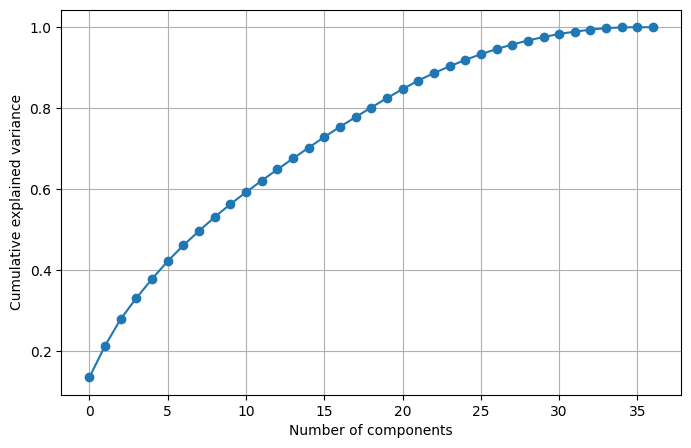

In [49]:
plt.figure(figsize=(8,5))
plt.plot(
    np.cumsum(pca_full.explained_variance_ratio_),
    marker="o"
)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.show()


O gráfico apresentado mostra a evolução da variância explicada à medida que o número de componentes aumenta. Observa-se que:
- As primeiras componentes principais concentram uma parte significativa da variância total;
- O ganho de variância explicada diminui progressivamente à medida que novas componentes são adicionadas;
- Isto indica a existência de correlações entre as features originais e alguma redundância de informação.

In [50]:
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

n_components_90 = np.argmax(explained_variance >= 0.90) + 1
n_components_95 = np.argmax(explained_variance >= 0.95) + 1

n_components_90, n_components_95


(24, 28)

Com base na variância explicada acumulada, foi determinado o número mínimo de componentes principais necessário para preservar uma percentagem significativa da informação original.

Os resultados indicam que:
- 24 componentes principais são suficientes para explicar pelo menos 90% da variância dos dados;
- 28 componentes principais permitem explicar 95% da variância.

## 9.3. Aplicação da PCA com Componentes Selecionadas e avaliação dos modelos

Após a seleção do número de componentes, foi aplicada a PCA aos dados normalizados de treino e teste.

A transformação resultou numa redução da dimensionalidade do conjunto de treino para 2100 amostras x 24 componentes, confirmando uma diminuição significativa do número de variáveis relativamente ao espaço original.

Esta redução permite simplificar os modelos subsequentes, diminuir a complexidade computacional e avaliar o impacto da PCA no desempenho dos classificadores.

In [51]:
pca = PCA(n_components=n_components_90)

In [52]:
pca = PCA(n_components=n_components_90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Shape after PCA transformation:", X_train_pca.shape)

Shape after PCA transformation: (2100, 24)


In [53]:
models = {
    "Random Forest": rf,
    "Best SVM": final_svm_model,
    "Pruned Decision Tree": best_dt
}

results_pca = []

for name, model in models.items():
    
    # Cross-validation using PCA-transformed training data
    cv_score = np.mean(cross_val_score(
        model,
        X_train_pca,
        y_train,
        cv=5,
        scoring="f1_weighted"
    ))
    
    # Fit and test using PCA-transformed data
    model.fit(X_train_pca, y_train)
    test_f1 = f1_score(y_test, model.predict(X_test_pca), average="weighted")

    results_pca.append([name, cv_score, test_f1])

results_pca_df = pd.DataFrame(
    results_pca,
    columns=["Model", "CV_F1_PCA", "Test_F1_PCA"]
)

print("\n### Model Performance With PCA Features ###")
print(results_pca_df)



### Model Performance With PCA Features ###
                  Model  CV_F1_PCA  Test_F1_PCA
0         Random Forest   0.824807     0.833400
1              Best SVM   0.837244     0.836946
2  Pruned Decision Tree   0.741333     0.744766


Após a aplicação da PCA e redução da dimensionalidade para 24 componentes principais, procedeu-se à avaliação do impacto desta transformação no desempenho dos modelos de classificação selecionados:
**Random Forest**, **Best SVM** e **Pruned Decisio Tree**

#### Resultados Obtidos com PCA:

**Random Forest**

- CV F1 (PCA): ≈ 0.825

- Test F1 (PCA): ≈ 0.833

**Best SVM**

- CV F1 (PCA): ≈ 0.837

- Test F1 (PCA): ≈ 0.837

**Pruned Decision Tree**

- CV F1 (PCA): ≈ 0.741

- Test F1 (PCA): ≈ 0.748

In [54]:
# Refit models on the ORIGINAL feature space before scoring original performance
rf.fit(X_train, y_train)
final_svm_model.fit(X_train, y_train)
best_dt.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=10, random_state=42)

In [55]:
results_compare = pd.DataFrame({
    "Model": ["RF", "SVM (best)", "DT Pruned"],
    "Original Test_F1": [
        f1_score(y_test, rf.predict(X_test), average="weighted"),
        f1_score(y_test, final_svm_model.predict(X_test), average="weighted"),
        f1_score(y_test, best_dt.predict(X_test), average="weighted")
    ],
    "PCA Test_F1": results_pca_df["Test_F1_PCA"]
})

results_compare


Model  Original Test_F1  PCA Test_F1
0          RF          0.912284     0.833400
1  SVM (best)          0.855811     0.836946
2   DT Pruned          0.849209     0.744766

## 9.4. Analise dos Resultados

#### A comparação direta evidencia que:

- A aplicação da PCA conduz a uma redução do desempenho em todos os modelos analisados;

- O impacto é particularmente significativo no **Random Forest**, que beneficia de features originais e relações não lineares;

- O **modelo SVM** apresenta maior robustez à redução de dimensionalidade, sofrendo apenas uma degradação moderada;

- A **Decision Tree** é o **modelo mais afetado pela PCA**, refletindo a perda de informação relevante nas componentes principais.

#### Com base nos resultados obtidos, conclui-se que, para este dataset:

- A PCA não melhora o desempenho dos modelos de classificação;

- A utilização das features originais conduz a melhores resultados;

- A PCA pode ser útil para redução de dimensionalidade e eficiência computacional, mas implica uma perda de capacidade preditiva.

(REVER) PCA did not improve model performance and is not an effective feature selection approach for this dataset. Models require access to original, non-linearly interacting features to accurately differentiate between classes. Regularized methods like Lasso were more successful at selecting relevant features while maintaining predictive performance.

### 10

In [67]:
# ===============================================================
# Dataset Setup
# ===============================================================
feature_names = [c for c in df_lasso.columns if c != "target_class"]
X = df_lasso[feature_names].values
y = df_lasso["target_class"].values

n_features = len(feature_names)

In [68]:
# ===============================================================
# Reinforcement Learning Configuration
# ===============================================================
import random

alpha = 0.1            # learning rate
gamma = 0.9            # discount factor
epsilon = 0.25         # exploration rate
epsilon_decay = 0.995
min_epsilon = 0.05
episodes = 60

penalty_per_feature = 0.01
negative_penalty = 0.05

In [69]:
# ===============================================================
# Use best SVM inside a preprocessing pipeline
# ===============================================================
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svm", final_svm_model)
])


In [70]:
# ===============================================================
# Q-Table and logging variables
# ===============================================================
Q = {}
episode_rewards = []
top_models = []

# Memoization cache to avoid repeated CV computation
reward_cache = {}

In [71]:
# ===============================================================
# Evaluate subset reward with memoization + parallel CV
# ===============================================================

def evaluate_subset(feature_mask):
    """Evaluate selected feature subset with caching."""
    key = tuple(feature_mask)

    # Return cached result if previously evaluated
    if key in reward_cache:
        return reward_cache[key]

    k = np.sum(feature_mask)
    if k == 0:
        reward_cache[key] = -1.0
        return -1.0

    X_subset = X[:, feature_mask == 1]

    # Best RF performance
    rf_score = cross_val_score(
        rf, X_subset, y, cv=3, scoring="f1_weighted", n_jobs=-1
    ).mean()

    # Best SVM with preprocessing
    svm_score = cross_val_score(
        svm_pipeline, X_subset, y, cv=3, scoring="f1_weighted", n_jobs=-1
    ).mean()

    best_score = max(rf_score, svm_score)

    penalty = penalty_per_feature * k

    reward = best_score - penalty

    # Cache result
    reward_cache[key] = reward

    return reward


In [72]:
# ===============================================================
# Epsilon-greedy action selection
# ===============================================================
def choose_action(state, available_actions):
    if random.random() < epsilon:
        return random.choice(available_actions)
    q_vals = [Q.get((state, a), 0) for a in available_actions]
    return available_actions[np.argmax(q_vals)]


In [73]:
# ===============================================================
# Q-Learning Loop (Corrected + Optimized)
# ===============================================================
for episode in range(episodes):
    state = np.zeros(n_features, dtype=int)
    done = False
    previous_acc = 0
    ep_reward = 0

    while not done:
        actions = [i for i in range(n_features) if state[i] == 0]
        actions.append("STOP")

        s_t = tuple(state)
        action = choose_action(s_t, actions)

        if action == "STOP":
            reward = evaluate_subset(state)
            done = True
            next_state = state.copy()
        else:
            next_state = state.copy()
            next_state[action] = 1
            new_acc = evaluate_subset(next_state)

            reward = new_acc - previous_acc
            if reward < 0:
                reward -= negative_penalty

            previous_acc = new_acc

        old_q = Q.get((s_t, action), 0)

        # SAFE FUTURE MAX-Q UPDATE
        if not done:
            next_actions = [a for a in range(n_features) if next_state[a] == 0]
            if len(next_actions) > 0:
                max_future_q = max(Q.get((tuple(next_state), a), 0) for a in next_actions)
            else:
                max_future_q = 0
        else:
            max_future_q = 0

        Q[(s_t, action)] = old_q + alpha * (reward + gamma * max_future_q - old_q)

        ep_reward += reward
        state = next_state


    episode_rewards.append(ep_reward)

    # Track Top-2 best subsets
    top_models.append((reward, state.copy()))
    top_models = sorted(top_models, key=lambda x: x[0], reverse=True)[:2]

    if episode % 1 == 0:
        print(f"Episode {episode}/{episodes} | Reward = {ep_reward:.4f}")

    epsilon = max(min_epsilon, epsilon * epsilon_decay)

print("\nRL Completed Successfully")

Episode 0/60 | Reward = -0.2523
Episode 1/60 | Reward = -0.2523
Episode 2/60 | Reward = -0.1523
Episode 3/60 | Reward = 0.1403
Episode 4/60 | Reward = 0.4839
Episode 5/60 | Reward = -0.3023
Episode 6/60 | Reward = -0.2060
Episode 7/60 | Reward = -0.3139
Episode 8/60 | Reward = -0.3023
Episode 9/60 | Reward = -0.0560
Episode 10/60 | Reward = -0.1842
Episode 11/60 | Reward = -0.1275
Episode 12/60 | Reward = -0.1560
Episode 13/60 | Reward = -0.2143
Episode 14/60 | Reward = -0.1060
Episode 15/60 | Reward = 0.7067
Episode 16/60 | Reward = 1.1636
Episode 17/60 | Reward = 1.1636
Episode 18/60 | Reward = -0.1560
Episode 19/60 | Reward = 0.7497
Episode 20/60 | Reward = 0.7674
Episode 21/60 | Reward = -0.0319
Episode 22/60 | Reward = -0.1951
Episode 23/60 | Reward = 0.0745
Episode 24/60 | Reward = 0.6893
Episode 25/60 | Reward = 0.0158
Episode 26/60 | Reward = -0.1253
Episode 27/60 | Reward = -0.0686
Episode 28/60 | Reward = -0.1753
Episode 29/60 | Reward = 0.0852
Episode 30/60 | Reward = -0.402

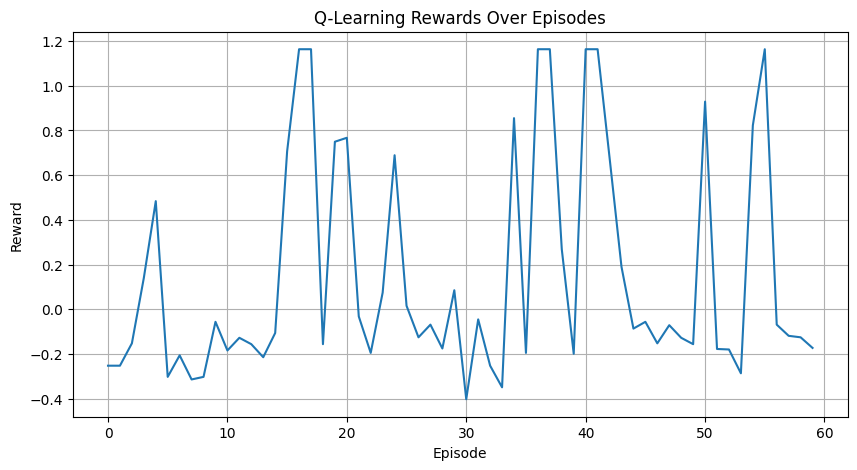

In [74]:
# ===============================================================
# Plot Training Convergence
# ===============================================================
plt.figure(figsize=(10,5))
plt.plot(episode_rewards)
plt.title("Q-Learning Rewards Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

In [75]:
# ===============================================================
# Build final evaluation results from Top-2 best subsets
# ===============================================================
final_results = []

for idx, (reward, state) in enumerate(top_models):
    selected_feats = [feature_names[i] for i in range(n_features) if state[i] == 1]
    X_sel = df_lasso[selected_feats].values

    rf_score = cross_val_score(
        rf, X_sel, y, cv=5, scoring="f1_weighted"
    ).mean()

    svm_score = cross_val_score(
        svm_pipeline, X_sel, y, cv=5, scoring="f1_weighted"
    ).mean()

    final_results.append({
        "Rank": idx + 1,
        "Reward": reward,
        "Num_Features": len(selected_feats),
        "Features": selected_feats,
        "RF_F1": rf_score,
        "SVM_F1": svm_score,
        "Best_Final_F1": max(rf_score, svm_score)
    })

results_rl_df = pd.DataFrame(final_results)
results_rl_df

Rank    Reward  Num_Features  \
0     1  0.581784             8   
1     2  0.581784             8   

                                            Features     RF_F1    SVM_F1  \
0  [duration_1, duration_2, duration_5, key_mode,...  0.670448  0.665551   
1  [duration_1, duration_2, duration_5, key_mode,...  0.670448  0.665551   

   Best_Final_F1  
0       0.670448  
1       0.670448

In [76]:
def print_top_features(results_df):
    for i in range(2):
        rank = i + 1
        reward = results_df.loc[i, "Reward"]
        features = results_df.loc[i, "Features"]
        num_feats = results_df.loc[i, "Num_Features"]
        
        print(f"\n===== TOP {rank} FEATURE SUBSET =====")
        print(f"Reward Score: {reward:.4f}")
        print(f"Number of Features: {num_feats}")
        print("Selected Features:")
        
        for feat in features:
            print(f"  • {feat}")

print_top_features(results_rl_df)



===== TOP 1 FEATURE SUBSET =====
Reward Score: 0.5818
Number of Features: 8
Selected Features:
  • duration_1
  • duration_2
  • duration_5
  • key_mode
  • album_freq
  • resonance_factor
  • distorted_movement
  • target_regression

===== TOP 2 FEATURE SUBSET =====
Reward Score: 0.5818
Number of Features: 8
Selected Features:
  • duration_1
  • duration_2
  • duration_5
  • key_mode
  • album_freq
  • resonance_factor
  • distorted_movement
  • target_regression


In [77]:
# Extract subsets
top1_feats = results_rl_df.loc[0, "Features"]
top2_feats = results_rl_df.loc[1, "Features"]

top1_reward = results_rl_df.loc[0, "Reward"]
top2_reward = results_rl_df.loc[1, "Reward"]

top1_n = results_rl_df.loc[0, "Num_Features"]
top2_n = results_rl_df.loc[1, "Num_Features"]

# Overlap analysis
common_feats = sorted(list(set(top1_feats).intersection(set(top2_feats))))
unique_top1 = sorted(list(set(top1_feats) - set(top2_feats)))
unique_top2 = sorted(list(set(top2_feats) - set(top1_feats)))


# Display output cleanly
def print_feature_summary(rank, reward, n_feats, feats):
    print(f"\n===== TOP {rank} FEATURE SUBSET =====")
    print(f"Reward Score: {reward:.4f}")
    print(f"Number of Features: {n_feats}")
    print("Selected Features:")
    for f in feats:
        print(f"  • {f}")


print_feature_summary(1, top1_reward, top1_n, top1_feats)
print_feature_summary(2, top2_reward, top2_n, top2_feats)

print("\n===== FEATURE OVERLAP ANALYSIS =====")
print(f"Common Features ({len(common_feats)}):")
for f in common_feats:
    print(f"  • {f}")

print(f"\nUnique to TOP 1 ({len(unique_top1)}):")
for f in unique_top1:
    print(f"  • {f}")

print(f"\nUnique to TOP 2 ({len(unique_top2)}):")
for f in unique_top2:
    print(f"  • {f}")



===== TOP 1 FEATURE SUBSET =====
Reward Score: 0.5818
Number of Features: 8
Selected Features:
  • duration_1
  • duration_2
  • duration_5
  • key_mode
  • album_freq
  • resonance_factor
  • distorted_movement
  • target_regression

===== TOP 2 FEATURE SUBSET =====
Reward Score: 0.5818
Number of Features: 8
Selected Features:
  • duration_1
  • duration_2
  • duration_5
  • key_mode
  • album_freq
  • resonance_factor
  • distorted_movement
  • target_regression

===== FEATURE OVERLAP ANALYSIS =====
Common Features (8):
  • album_freq
  • distorted_movement
  • duration_1
  • duration_2
  • duration_5
  • key_mode
  • resonance_factor
  • target_regression

Unique to TOP 1 (0):

Unique to TOP 2 (0):
